# Reservoir curves - US
***

In [1]:
import pandas as pd
import geopandas as gpd
from datetime import datetime
from pathlib import Path
#import matplotlib.pyplot as plt
from scipy.stats import spearmanr

from lisfloodreservoirs import read_attributes, read_timeseries
from lisfloodreservoirs.utils.reservoir_curves import *

## Config

In [2]:
country = 'US'
long_name = 'United States'

path_datasets = Path('/home/chus-casado/Datos')

## Data

### ResOpsUS

In [3]:
path_resops = path_datasets / 'reservoirs' / 'ResOpsUS' / 'v2.2'

# list of selected reservoirs
res_list = pd.read_csv(path_resops / 'selection' / 'reservoirs.txt', header=None).squeeze().tolist()

# load reservoir attributes
resops_attrs = read_attributes(
    path=path_resops / 'attributes',
    reservoirs=res_list,
    index_col='GRAND_ID',
)

# load time series
resops_ts = read_timeseries(
    path=path_resops / 'time_series' / 'csv',
    reservoirs=resops_attrs.index,
    variables=['elevation', 'storage']
)
# keep only reservoirs with both elevation and storage data
resops_ts = {
    grand_id: df for grand_id, df in resops_ts.items() 
    if all(col in df.columns for col in ['elevation', 'storage'])
    }
print(f'/n Number of reservoirs with elevation and storage data: {len(resops_ts)}')
# convert storage units to hm3
for grand_id, df in resops_ts.items():
    if 'storage' in df.columns:
        df.storage *= 1e-6

  0%|          | 0/164 [00:00<?, ?it/s]

Time series for ID 55 is missing variables: {'elevation'}
Time series for ID 57 is missing variables: {'elevation'}
Time series for ID 60 is missing variables: {'elevation'}
Time series for ID 63 is missing variables: {'elevation'}
Time series for ID 131 is missing variables: {'elevation'}
Time series for ID 132 is missing variables: {'elevation'}
Time series for ID 133 is missing variables: {'elevation'}
Time series for ID 148 is missing variables: {'elevation'}
Time series for ID 180 is missing variables: {'elevation'}
Time series for ID 191 is missing variables: {'elevation'}
Time series for ID 193 is missing variables: {'elevation'}
Time series for ID 198 is missing variables: {'elevation'}
Time series for ID 214 is missing variables: {'elevation'}
Time series for ID 297 is missing variables: {'elevation'}
Time series for ID 361 is missing variables: {'elevation'}
Time series for ID 367 is missing variables: {'elevation'}
Time series for ID 372 is missing variables: {'elevation'}
T

### Global Dam Watch

In [4]:
# load GDW reservoirs in the country
path_gdw = path_datasets / 'reservoirs' / 'GDW' / 'GDW_v1_0_shp'
gdw = gpd.read_file(path_gdw / 'GDW_barriers_v1_0.shp').set_index('GRAND_ID')
gdw = gdw[gdw.COUNTRY == long_name]
print(f'GDW contains {len(gdw)} reservoirs in {long_name}')

# reduce reservoirs to those in both GDW and ResOps datasets
grand_ids = gdw.index.intersection(resops_ts.keys())
gdw = gdw.loc[grand_ids]
resops_ts = {grand_id: resops_ts[grand_id] for grand_id in grand_ids}
print(f'{len(grand_ids)} are both in GDW and ResOps datasets')

GDW contains 4862 reservoirs in United States
138 are both in GDW and ResOps datasets


## Reservoir curves

### Extract data

In [5]:
#grand_id = 169 #41 # 549 # 355
#start = datetime(2002, 1, 1)

#grand_id = 320
#start = datetime(2010, 1, 1)

grand_id = 41
start = None

# attributes
dam_hgt_m, elev_masl, cap_mcm, area_skm = gdw.loc[grand_id, ['DAM_HGT_M', 'ELEV_MASL', 'CAP_MCM', 'AREA_SKM']]
z_min = elev_masl - dam_hgt_m

# extract data 
obs = resops_ts[grand_id].loc[start:].copy()
obs.dropna(axis=0, how='any', inplace=True)
mask = (obs.elevation < z_min) | (obs.elevation > elev_masl)
print(f'{mask.sum()} observation outside the elevation range')

# estimate area curve
obs['area'] = obs.storage.diff() / obs.elevation.diff()
obs.loc[obs.area < 0, 'area'] = np.nan

#fig, axes = plot_reservoir_curves(attrs=gdw.loc[grand_id], obs=obs)
rho, p_value = spearmanr(obs.elevation, obs.storage)
#axes[0,0].text(0.05, 0.9, f'Spearman ρ={rho:.2f} (p={p_value:.2g})', transform=axes[0,0].transAxes);

0 observation outside the elevation range


### Preprocess data

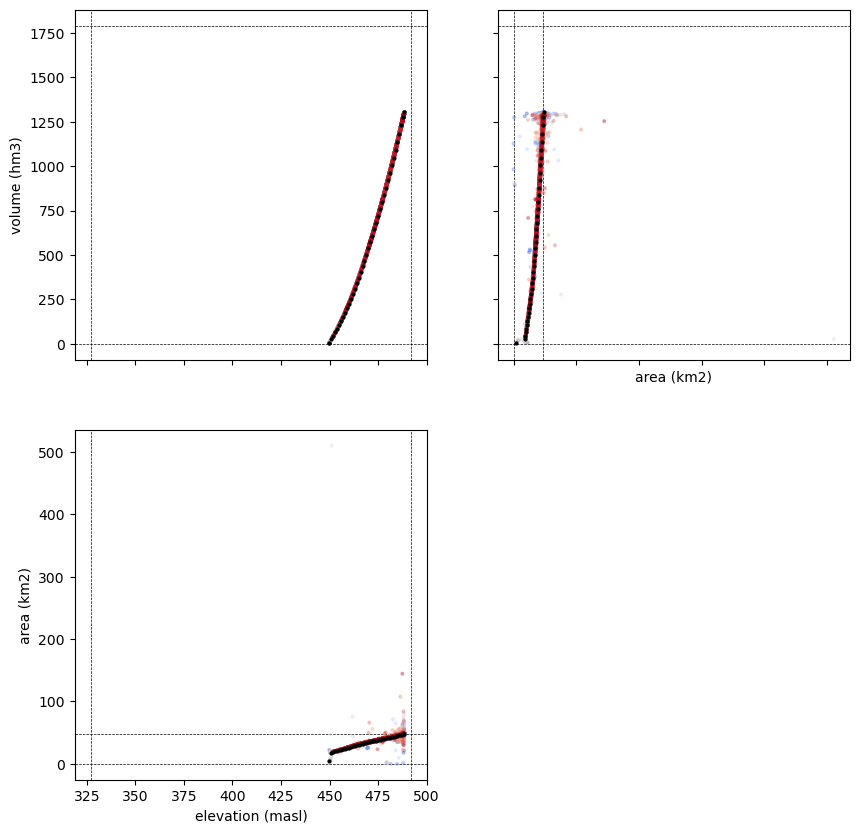

In [8]:
bin_size = 1
# clean outliers
if rho < 0.9:
    remove_outliers_kde(obs, 'elevation', 'storage', threshold_density=0.0001, inplace=True)

# compute bin medians
train_data = bin_data(obs.elevation, obs['storage'], agg='closest', bin_size=bin_size)

# add maximum and minimum capacity
#if train_data.index.max() < elev_masl and train_data.storage.max() < cap_mcm:
#    train_data.loc[elev_masl, 'storage'] = cap_mcm
#train_data.loc[z_min] = 0
#train_data.sort_index(inplace=True)

# estimate average area
#train_data['area'] = estimate_area_curve(train_data)
train_data['area'] = train_data.storage.diff() / train_data.elevation.diff()

fig, axes = plot_reservoir_curves(attrs=gdw.loc[grand_id], obs=obs)
for j, var_x in enumerate(['elevation', 'area']):
    for i, var_y in enumerate(['storage', 'area']):
        ax = axes[i,j]
        if i == 1 & j == 1:
            continue
        ax.scatter(
            train_data[var_x], 
            train_data[var_y], 
            c='k', 
            s=4,
            zorder=5,
            label='binned data'
        )

### Fit curve

In [55]:
class ReservoirCurve(pd.DataFrame):
    """
    Enhanced pandas.DataFrame subclass for Elevation-Area-Storage (EAS) curve analysis.

    The ReservoirCurve object stores the lookup table data and provides methods
    for fitting and inferring values between elevation, storage, and area time series.
    It automatically enforces monotonicity and respects defined physical limits
    (z_min, z_max, v_max, etc.) to prevent non-physical extrapolation.

    Attributes:
        z_min (float): Minimum physical elevation (e.g., dam invert).
        z_max (float): Maximum physical elevation (e.g., dam crest).
        v_min (float): Minimum observed storage (always >= 0).
        v_max (float): Maximum physical storage capacity.
        curve_zv (callable): Fitted interpolator for Elevation -> Storage (set by .fit()).
        curve_vz (callable): Fitted interpolator for Storage -> Elevation (set by .fit()).
    """
    
    def __init__(self, lookup_table: pd.DataFrame, *args, **kwargs):
        """
        Initializes the ReservoirCurve object.

        Parameters
        ----------
        lookup_table : pd.DataFrame
            A DataFrame containing the EAS curve data. Must include 'elevation' (z)
            and 'storage' (v). Data must be monotonically
            increasing with elevation.
        *args, **kwargs :
            Arguments passed to the pandas.DataFrame constructor.

        Raises
        ------
        ValueError
            If 'elevation' or 'storage' columns are missing, or if storage/area
            are not monotonically increasing with elevation, or if observed data
            exceeds user-defined limits.
        """
        super().__init__(lookup_table, *args, **kwargs)

        # check monotonicity
        self.sort_values('elevation', inplace=True)
        self.reset_index(inplace=True, drop=True)
        if not self['storage'].is_monotonic_increasing:
            raise ValueError("The 'storage' column must be monotonically increasing with 'elevation'. Check data quality.")

        # define curve limits
        self.z_min = self['elevation'].min()
        self.z_max = self['elevation'].max()
        self.v_min = self['storage'].min()
        self.v_max = self['storage'].max()

        # initialize empty curves
        self.curve_zv = None
        self.curve_vz = None

    def fit(self, method: Literal['poly', 'interp1d', 'pchip'] = 'pchip', degree: int = 2):
        """
        Fits the forward (Elevation -> Storage) and inverse (Storage -> Elevation) 
        curves using the data stored in the ReservoirCurve lookup table.
    
        It supports polynomial fitting, linear interpolation, 
        and shape-preserving cubic Hermite interpolation (PCHIP).
    
        Parameters
        ----------
        method : {'poly', 'interp1d', 'pchip'}, optional
            The fitting method to use:
            - 'poly' fits a polynomial of specified degree (e.g., quadratic).
            - 'interp1d' performs linear interpolation.
            - 'pchip' uses shape-preserving cubic Hermite interpolation (default).
        degree : int, optional
            Degree of the polynomial if `method='poly1d'`. Ignored for other methods. 
            Default is 2.
    
        Returns
        -------
        callable
            A function that takes elevation values as input and returns estimated 
            storage values. The return type depends on the method:
            - `np.Polynomial` for polynomial fitting,
            - `scipy.interpolate.interp1d` for linear interpolation,
            - `scipy.interpolate.PchipInterpolator` for PCHIP.
        
        Raises
        ------
        ValueError
            If an unsupported fitting method is specified.
        """
    
        if method.lower() == 'poly':
            # elevation-storage curve
            coefficients_zv = np.polyfit(self.elevation, self.storage, degree)
            self.curve_zv = np.Polynomial(coefficients_zv[::-1])
            # storage-elevation curve
            coefficients_vz = np.polyfit(self.storage, self.elevation, degree)
            self.curve_vz = np.Polynomial(coefficients_vz[::-1])
        elif method.lower() == 'interp1d':
            # elevation-storage curve
            self.curve_zv = interp1d(
                x=self.elevation,
                y=self.storage,
                kind='linear',
                #fill_value='extrapolate',
                assume_sorted=True
                )
            # storage-elevation curve
            self.curve_vz = interp1d(
                x=self.storage,
                y=self.elevation,
                kind='linear',
                #fill_value='extrapolate',
                assume_sorted=True
            )
        elif method.lower() == 'pchip':
            # elevation-storage curve
            self.curve_zv = PchipInterpolator(x=self.elevation, y=self.storage)
            # storage-elevation curve
            self.curve_vz = PchipInterpolator(x=self.storage, y=self.elevation)
        else:
            raise ValueError(f'"method" must be either "poly", "interp1d" or "pchip": {method} was provided')

    def _check_range(self, data: Union[pd.Series, np.ndarray], variable: Literal['elevation', 'storage']) -> Union[pd.Series, np.ndarray]:
        """Converts into NaN values outside the reservoir curve range to avoid extrapolation problems

        Parameters:
        -----------
        data: pandas.Series or numpy.ndarray
            Values to be checked
        variable: string
            Defines the variable of "data"

        Returns:
        --------
        np.ndarray
            The input data with out-of-range values set to NaN.
        """
        array = np.array(data)
        
        if variable == 'elevation':
            min_value, max_value = self.z_min, self.z_max
        elif variable == 'storage':
            min_value, max_value = self.v_min, self.v_max
        else:
            raise ValueError(f'"variable" must be either "elevation" or "storage": {variable} was provided')
        
        mask = (data < min_value) | (data > max_value)
        if mask.sum() > 0:
            data[mask] = np.nan
            print(f'WARNING. {mask.sum()} {variable} values were removed because they were outside of the range [{min_value:.3f},{max_value:.3f}]')

        return data
        
    def storage_from_elevation(self, elevation: Union[pd.Series, np.ndarray]) -> Union[pd.Series, np.ndarray]:
        """
        Produces a time series of reservoir storage given an elevation time series.
    
        Parameters:
        -----------
        elevation: pandas.Series or numpy.ndarray
            Reservoir elevation data
    
        Returns:
        --------
        storage: pandas.Series or numpy.ndarray
            Estimated reservoir storage data
        """
        # check values within the curve's elevation range
        elevation = elevation.copy()
        self._check_range(elevation, variable='elevation')
        
        # estimate storage
        storage = self.curve_zv(elevation)
        self._check_range(storage, variable='storage')
        if isinstance(elevation, pd.Series):
            storage = pd.Series(data=storage, index=elevation.index, name='storage')
        return storage

    def elevation_from_storage(self, storage: Union[pd.Series, np.ndarray]) -> Union[pd.Series, np.ndarray]:
        """
        Produces a time series of reservoir elevation given a storage time series.
    
        Parameters:
        -----------
        storage: pandas.Series or numpy.ndarray
            Reservoir storage data
    
        Returns:
        --------
        elevation: pandas.Series or numpy.ndarray
            Estimated reservoir elevation data
        """
    
        # check values within the curve's elevation range
        storage = storage.copy()
        storage = self._check_range(storage, variable='storage')     
        
        # estimate elevation
        elevation = self.curve_vz(storage)
        elevation = self._check_range(elevation, variable='elevation')
        if isinstance(storage, pd.Series):
            elevation = pd.Series(data=elevation, index=storage.index, name='elevation')

        return elevation

    def plot(
        self,
        attrs: Optional[pd.Series] = None,
        obs: Optional[pd.DataFrame] = None,
        **kwargs
        ):
        """
        Generates a 2x2 matrix of scatter plots showing the relationships between
        reservoir elevation, area, and storage (volume), which are collectively 
        known as the reservoir's characteristic curves.
    
        The function plots the three essential relationships:
        1. Elevation vs. Storage (Volume)
        2. Elevation vs. Area
        3. Area vs. Storage (Volume)
    
        The fourth subplot (Area vs. Area) is left blank. Reference lines for 
        key values (e.g., minimum/maximum elevation, maximum area/storage) are 
        drawn based on external variables (`elev_masl`, `dam_hgt_m`, `area_skm`, 
        `cap_mcm`) that must be defined in the global or enclosing scope.
    
        Parameters:
        -----------
        attrs: pandas.Series (optional)
            An optional Series containing reservoir attributes from GRanD or GDW 
            such as 'DAM_HGT_M', 'ELEV_MASL', 'AREA_SKM' or 'CAP_MCM' to draw 
            reference lines on the plots. Defaults to None.
        obs: pandas.DataFrame (optional)
            An optional DataFrame containing observed reservoir data to overlay on 
            the plots. Defaults to None.
            
        **kwargs: Optional keyword arguments to customize the plot:
            - figsize (tuple, optional): Size of the figure (width, height). 
              Defaults to (10, 10).
    
        Returns:
        --------
        tuple: [plt.Figure, np.ndarray]
            A tuple containing:
            - fig (matplotlib.figure.Figure): The main Matplotlib figure object.
            - axes (np.ndarray): A 2x2 array of Matplotlib axes objects.
        """
        alpha = kwargs.get('alpha', 0.3)
        cmap = kwargs.get('cmap', 'coolwarm')
        figsize = kwargs.get('figsize', (10, 10))
        size = kwargs.get('size', 4)
        
        fig, axes = plt.subplots(ncols=2, nrows=2, figsize=figsize, sharex='col', sharey='row')
    
        if attrs is not None:
            dam_hgt_m, elev_masl, cap_mcm, area_skm = attrs.loc[['DAM_HGT_M', 'ELEV_MASL', 'CAP_MCM', 'AREA_SKM']]
        var_props = {
            'elevation': {
                'label': 'elevation (masl)',
                'ref': [elev_masl - dam_hgt_m, elev_masl] if attrs is not None else []
            },
            'area': {
                'label': 'area (km2)',
                'ref': [0, area_skm] if attrs is not None else [0]
            },
            'storage': {
                'label': 'volume (hm3)',
                'ref': [0, cap_mcm] if attrs is not None else [0]
            }
        }
    
        aux_props = dict(ls='--', lw=.5, c='k', zorder=0)
        obs_props = dict(cmap=cmap, s=size, alpha=alpha, zorder=1)
        lookup_props = dict(s=size * 2, lw=.6, c='k', marker='+', alpha=1, zorder=2)
        curve_props = dict(lw=1, c='k', zorder=3)
        
        for j, var_x in enumerate(['elevation', 'area']):
            for i, var_y in enumerate(['storage', 'area']):
                ax = axes[i,j]
                if i == 1 & j == 1:
                    ax.axis('off')
                    continue

                # lookup table
                if (var_x in self.columns) and (var_y in self.columns):
                    label = 'reservoir_curve' if (i == 0 and j == 0) else None
                    ax.scatter(self[var_x], self[var_y], **lookup_props, label=label)
                
                # fitted curves
                if self.curve_zv is not None:
                    if var_x == 'elevation':
                        x_values = np.linspace(self.z_min, self.z_max, 100)
                        if var_y == 'storage':
                            ax.plot(x_values, self.curve_zv(x_values), **curve_props, label='reseroir curve')
                        #if var_y == 'area':
                            #ax.plot(x_values, self.curve_za(x_values), **curve_props)
                    #elif var_x == 'area':
                        #x_values = np.linspace(self.a_min, self.a_max, 100)
                        #if var_y == 'storage':
                            #ax.plot(x_values, self.curve_av(x_values), **curve_props)
    
                # scatter plot of observed data
                if obs is not None and all(col in obs.columns for col in [var_x, var_y]):
                    label = 'observations' if (i == 0 and j == 0) else None
                    ax.scatter(obs[var_x], obs[var_y], c=obs.index, **obs_props, label=label)
                    
                for x in var_props[var_x]['ref']:
                    ax.axvline(x, **aux_props)
                for y in var_props[var_y]['ref']:
                    ax.axhline(y, **aux_props)
    
                if (i == 1) | (j == 1):
                    ax.set_xlabel(var_props[var_x]['label'])
                if j == 0:
                    ax.set_ylabel(var_props[var_y]['label'])
    
        return fig, axes

In [56]:
# initialize class
reservoir_curve = ReservoirCurve(train_data)
reservoir_curve.fit(method='pchip')

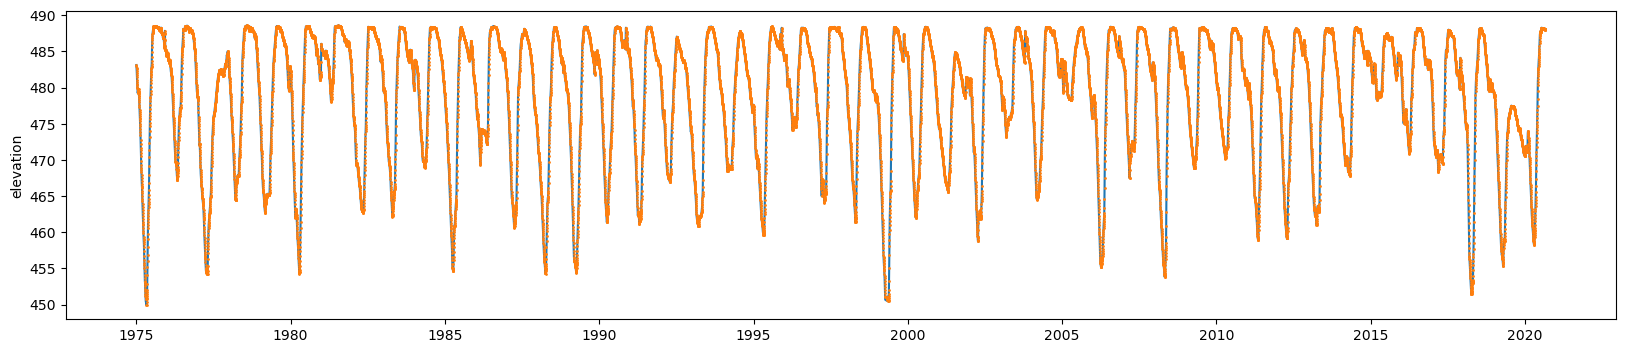

In [57]:
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(obs.elevation)
ax.plot(reservoir_curve.elevation_from_storage(obs.storage), 'o', markersize=1)
#ax.set_xlim(datetime(1998, 1,1 ), datetime(2000, 1, 1));
ax.set_ylabel('elevation');

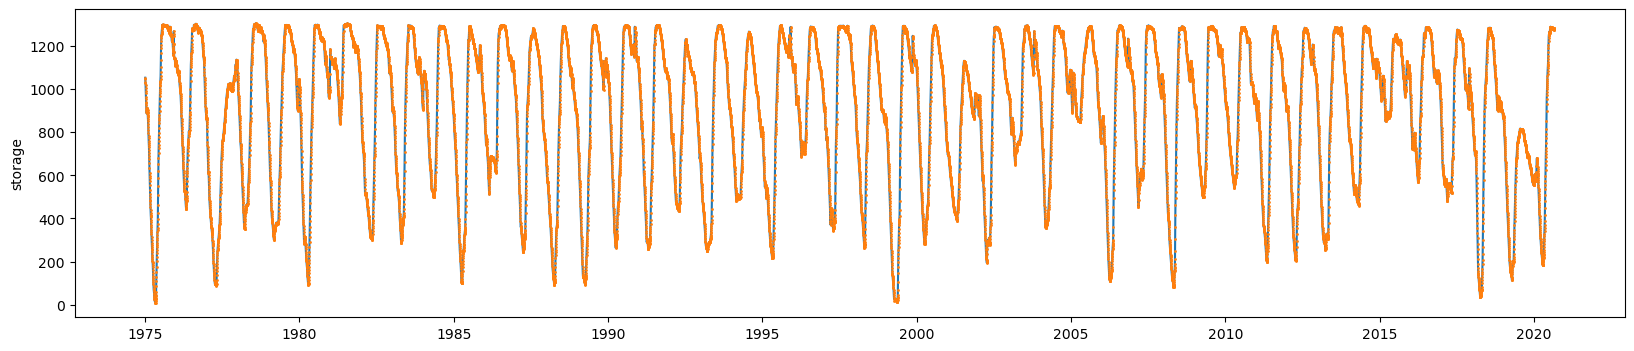

In [58]:
fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(obs.storage)
ax.plot(reservoir_curve.storage_from_elevation(obs.elevation), 'o', markersize=1)
#ax.set_xlim(datetime(1998, 1,1 ), datetime(2000, 1, 1));
ax.set_ylabel('storage');

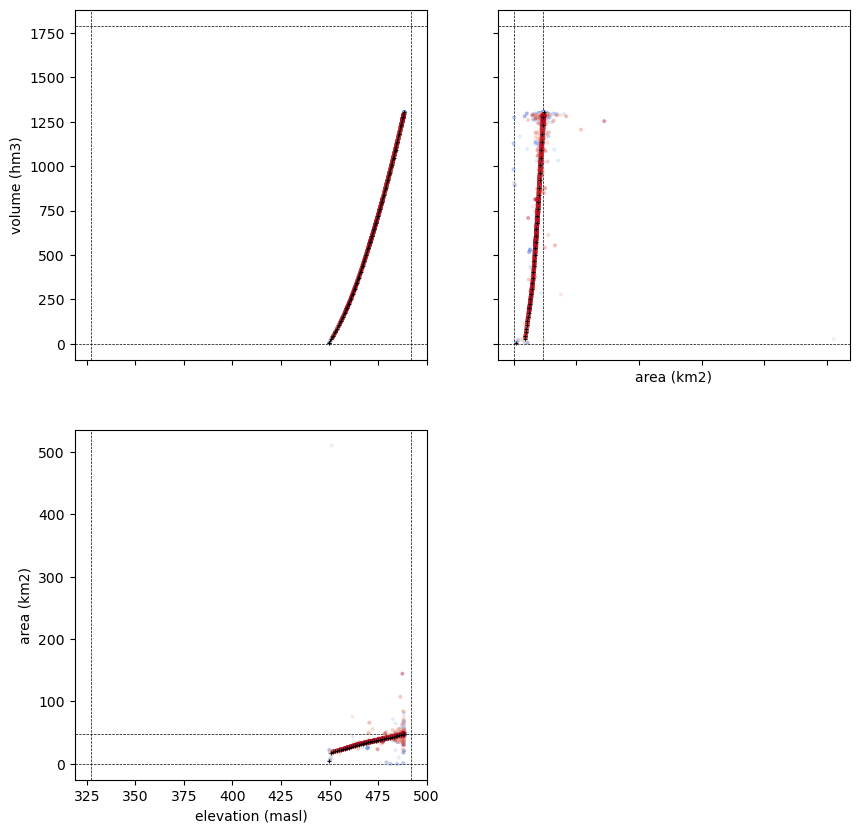

In [59]:
fig, axes = reservoir_curve.plot(attrs=gdw.loc[grand_id], obs=obs)

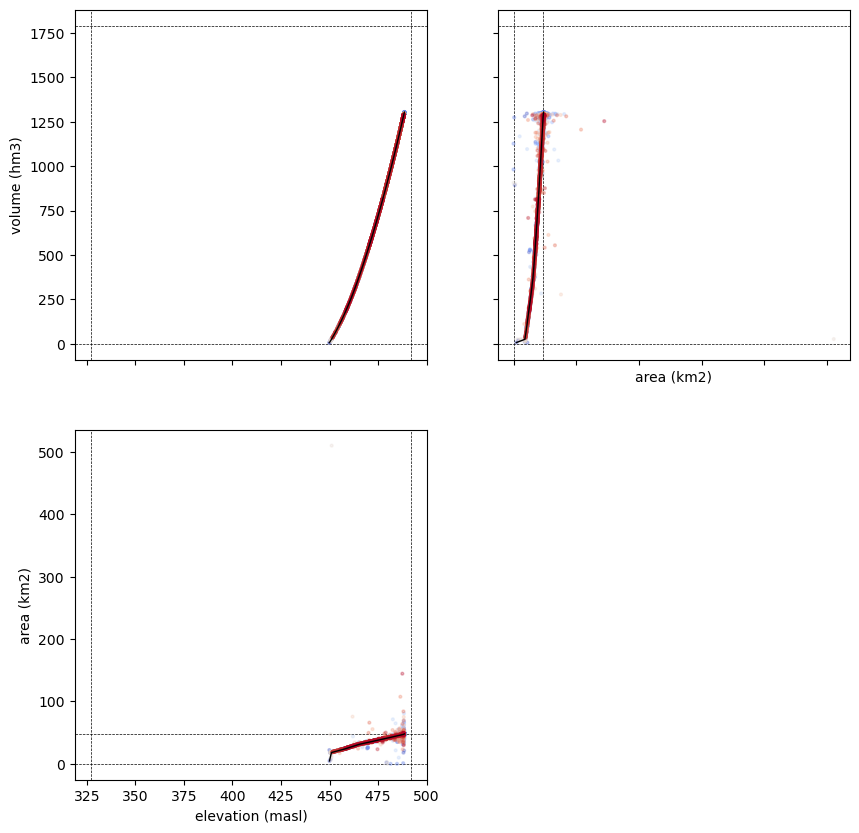

In [60]:
fig, axes = plot_reservoir_curves(reservoir_curve=reservoir_curve, attrs=gdw.loc[grand_id], obs=obs)